In [ ]:
import pandas as pd
from datetime import date
import requests
import numpy as np
from bs4 import BeautifulSoup
import re
import os
import matplotlib.pyplot as plt

url= "https://www.olx.pt/imoveis/casas-moradias-para-arrendar-vender/moradias-venda/lisboa/?search%5Border%5D=relevance%3Adesc&view=list"

headers = { "User-Agent": "Chrome/91.0.4472.114" }
response = requests.get(url, headers=headers)
response

<Response [200]>

In [ ]:
soup = BeautifulSoup(response.content)

houses = soup.find_all("div", attrs= {"class":"css-qfzx1y"})
len(houses)          #checking for the number of output data

46

In [ ]:
# We are going to find the house type, price, location, date of advertisement and area of the house
# inspections reference for web scraping

filename=""

def get_houses(city, page_number):
    print(f"Página N.º: {page_number}  da cidade {city}")
    url = f"https://www.olx.pt/imoveis/casas-moradias-para-arrendar-vender/moradias-venda/{city}/?page={page_number}&search%5Border%5D=relevance%3Adesc&view=list"
    headers = {"User-Agent": "Chrome/91.0.4472.114"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    houses = soup.find_all("div", attrs={"class": "css-qfzx1y"})

    house_dict = {}  # Creating a dictionary
    index = 0

    for house in houses:
        title = house.find_all("h6", attrs={"class": "css-1wxaaza"})[0].get_text()
        price = house.find_all("p", attrs={"class": "css-13afqrm"})[0].get_text()
        location_date = house.find_all("p", attrs={"class": "css-1mwdrlh"})[0].get_text()
        size = house.find_all("span", attrs={"class": "css-643j0o"})[0].get_text()
        house_dict[index] = {
            "title": title,
            "price": price,
            "location_date": location_date,
            "size": size
        }
        index += 1

    return pd.DataFrame.from_dict(house_dict, orient="index")

In [ ]:
# Function to scrape data for a list of cities and store in CSV files
def scrape_and_store_data(cities, page_number):
    #for city in cities:
        all_pages_data = pd.DataFrame()  # Initialize an empty DataFrame to accumulate data

        for page in range(1, page_number + 1):
            # Scrape data for the current page of the current city
            city_data = get_houses(city, page)
            # Accumulate the data
            all_pages_data = pd.concat([all_pages_data, city_data], ignore_index=True)

        # Create a filename for the current city
        filename = f"{city}_houses.csv"

        # Save the accumulated data to a CSV file
        all_pages_data.to_csv(filename, index=False)
        print(f"Data for {city} saved to {filename}")

In [ ]:
# List of cities to scrape
cities = ["lisboa", "porto", "braga", "aveiro", "coimbra", "faro"]

#Number of pages to scrape
page_number = 40
# Run the function for the specified cities and page number
for city in cities:
  scrape_and_store_data(city, page_number)
print("Data scraping for all cities completed.")

Página N.º: 1  da cidade lisboa
Página N.º: 2  da cidade lisboa
Página N.º: 3  da cidade lisboa
Página N.º: 4  da cidade lisboa
Página N.º: 5  da cidade lisboa
Página N.º: 6  da cidade lisboa
Página N.º: 7  da cidade lisboa
Página N.º: 8  da cidade lisboa
Página N.º: 9  da cidade lisboa
Página N.º: 10  da cidade lisboa
Página N.º: 11  da cidade lisboa
Página N.º: 12  da cidade lisboa
Página N.º: 13  da cidade lisboa
Página N.º: 14  da cidade lisboa
Página N.º: 15  da cidade lisboa
Página N.º: 16  da cidade lisboa
Página N.º: 17  da cidade lisboa
Página N.º: 18  da cidade lisboa
Página N.º: 19  da cidade lisboa
Página N.º: 20  da cidade lisboa
Página N.º: 21  da cidade lisboa
Página N.º: 22  da cidade lisboa
Página N.º: 23  da cidade lisboa
Página N.º: 24  da cidade lisboa
Página N.º: 25  da cidade lisboa
Página N.º: 26  da cidade lisboa
Página N.º: 27  da cidade lisboa
Página N.º: 28  da cidade lisboa
Página N.º: 29  da cidade lisboa
Página N.º: 30  da cidade lisboa
Página N.º: 31  da 

In [ ]:
def read_and_concat_csv_files(cities):
    dataframes = []
    for city in cities:
        filename = f"{city}_houses.csv"
        if os.path.exists(filename):
            city_data = pd.read_csv(filename)
            city_data['city'] = city  # Add a column with the city name
            dataframes.append(city_data)
        else:
            print(f"File {filename} not found.")

    if dataframes:
        City_Houses_DF = pd.concat(dataframes, ignore_index=True)
        return City_Houses_DF
    else:
        print("No dataframes to concatenate.")
        return pd.DataFrame()

In [ ]:
# List of cities
cities = ["lisboa", "porto", "braga", "aveiro", "coimbra", "faro"]

# Run the function to read and concatenate CSV files
City_Houses_DF = read_and_concat_csv_files(cities)
City_Houses_DF.shape

(11189, 5)

In [ ]:
def extract_house_typology(title):
    typology_match = re.search(r'\bT\d{1,2}\b', title, re.IGNORECASE)
    if typology_match:
        return typology_match.group(0).upper()
    return None

In [ ]:
def extract_house_type(title):
    types = ['Apartamentos', 'Moradia', 'Casa', 'Casas de Férias', 'Terreno', 'Quinta']
    for house_type in types:
        if house_type.lower() in title.lower():
            return house_type
    return None

In [ ]:
def process_entries(City_Houses_DF):
    for entry_id, entry in City_Houses_DF.items():
        title = entry.get('title', '')
        house_typology = extract_house_typology(title)
        house_type = extract_house_type(title)

        if house_typology:
            City_Houses_DF['house_typology'] = house_typology
        if house_type:
            City_Houses_DF['house_type'] = house_type
        else:
            # Assuming default house type as 'Moradia' if not specified
            City_Houses_DF['house_type'] = 'Moradia'

    return City_Houses_DF

In [ ]:
df=City_Houses_DF
def process_entries(df):
    City_Houses_DF['house_typology'] = City_Houses_DF['title'].apply(extract_house_typology)
    City_Houses_DF['house_type'] = City_Houses_DF['title'].apply(extract_house_type)
    #df['house_type'].fillna('Moradia', inplace=True)  # Assuming default house type as 'Moradia' if not specified
    return df
df

,title,price,location_date,size,city
0,A Moradia T7 dos Seus Sonhos Espera por Você,498.000 €,Silveira - 22 de julho de 2024,256 m²,lisboa
1,"MAFRA - QUINTA, com Moradia Arquitetura Tradic...",1.800.000 €,Mafra - Para o topo Hoje às 10:49,41.652 m²,lisboa
2,Moradia Semi-nova em Caneças - EXCELENTES ACAB...,615.000 €,Ramada E Caneças - 25 de julho de 2024,173 m²,lisboa
3,Moradia T5 Piscina Cascais/Murtal,1.050.000 €,Carcavelos E Parede - Hoje às 16:08,250 m²,lisboa
4,Moradia independente T4 com jardim e piscina e...,950.000 €,Rio de Mouro - Hoje às 16:04,405 m²,lisboa
...,...,...,...,...,...
11184,Moradia típica da vila da Fuseta recuperada co...,295.000 €,Moncarapacho E Fuseta - 24 de julho de 2024,64 m²,faro
11185,Excelente Moradia T4 em Altura,530.000 €,Altura - 24 de julho de 2024,"201,21 m²",faro
11186,Moradia térrea para venda T2+1 no Alg...,318.000 €,Algoz E Tunes - 24 de julho de 2024,80 m²,faro
11187,"Moradia Isolada V3+1 com vista para a Serra, p...",1.050.000 €,Alte - 24 de julho de 2024,232 m²,faro


In [ ]:
updated_entries = process_entries(City_Houses_DF)

In [ ]:
City_Houses_DF

,title,price,location_date,size,city,house_typology,house_type
0,A Moradia T7 dos Seus Sonhos Espera por Você,498.000 €,Silveira - 22 de julho de 2024,256 m²,lisboa,T7,Moradia
1,"MAFRA - QUINTA, com Moradia Arquitetura Tradic...",1.800.000 €,Mafra - Para o topo Hoje às 10:49,41.652 m²,lisboa,None,Moradia
2,Moradia Semi-nova em Caneças - EXCELENTES ACAB...,615.000 €,Ramada E Caneças - 25 de julho de 2024,173 m²,lisboa,None,Moradia
3,Moradia T5 Piscina Cascais/Murtal,1.050.000 €,Carcavelos E Parede - Hoje às 16:08,250 m²,lisboa,T5,Moradia
4,Moradia independente T4 com jardim e piscina e...,950.000 €,Rio de Mouro - Hoje às 16:04,405 m²,lisboa,T4,Moradia
...,...,...,...,...,...,...,...
11184,Moradia típica da vila da Fuseta recuperada co...,295.000 €,Moncarapacho E Fuseta - 24 de julho de 2024,64 m²,faro,None,Moradia
11185,Excelente Moradia T4 em Altura,530.000 €,Altura - 24 de julho de 2024,"201,21 m²",faro,T4,Moradia
11186,Moradia térrea para venda T2+1 no Alg...,318.000 €,Algoz E Tunes - 24 de julho de 2024,80 m²,faro,T2,Moradia
11187,"Moradia Isolada V3+1 com vista para a Serra, p...",1.050.000 €,Alte - 24 de julho de 2024,232 m²,faro,None,Moradia


In [ ]:
def clean_and_convert_columns(df):
    # Remove all letters and spaces in the price column, then convert to float
    df['price'] = df['price'].apply(lambda x: re.sub(r'[^\d,]', '', x).replace(',', '.') if isinstance(x, str) else x)
    df['price'] = df['price'].astype(float)
    df.rename(columns={'price': 'price_in_euros'}, inplace=True)

    # Extract numeric part from size column, convert to integer
    df['size'] = df['size'].apply(lambda x: int(re.findall(r'\d+', x)[0]) if pd.notnull(x) else None)
    df.rename(columns={'size': 'size_m2'}, inplace=True)
    return df

In [ ]:
# Assuming City_Houses_DF is the concatenated DataFrame from previous steps
City_Houses_DF = clean_and_convert_columns(City_Houses_DF)

In [ ]:

City_Houses_DF.drop_duplicates(inplace=True, ignore_index=True)                                       # Removing duplicates
City_Houses_DF = City_Houses_DF.drop(City_Houses_DF[City_Houses_DF["size_m2"] < 20].index)            #removing small house areas
City_Houses_DF = City_Houses_DF.drop(City_Houses_DF[City_Houses_DF["price_in_euros"] < 20000].index)            #removing small house areas


In [ ]:
City_Houses_DF

,title,price_in_euros,location_date,size_m2,city,house_typology,house_type,price_per_m2
0,Moradia T5 Piscina Cascais/Murtal,1050000.0,Carcavelos E Parede - Hoje às 16:08,250,lisboa,T5,Moradia,4200.000000
1,Moradia independente T4 com jardim e piscina e...,950000.0,Rio de Mouro - Hoje às 16:04,405,lisboa,T4,Moradia,2345.679012
2,Moradia T5 com piscina e jardim na Serra de Ca...,699000.0,Venteira - Hoje às 16:02,204,lisboa,T5,Moradia,3426.470588
3,Moradia T4,469000.0,"Alhandra, São João Dos Montes E Calhandriz - H...",231,lisboa,T4,Moradia,2030.303030
4,Moradia T5 Em Carcavelos Com Piscina E Jardim...,1350000.0,Carcavelos E Parede - Hoje às 16:01,139,lisboa,T5,Moradia,9712.230216
...,...,...,...,...,...,...,...,...
3402,Moradia T4 - Altura,430000.0,Altura - 24 de julho de 2024,137,faro,T4,Moradia,3138.686131
3403,Moradia T2+2 em Construção,393000.0,Vila Nova de Cacela - 24 de julho de 2024,93,faro,T2,Moradia,4225.806452
3404,Moradia T2+2 em Construção,384000.0,Vila Nova de Cacela - 24 de julho de 2024,108,faro,T2,Moradia,3555.555556
3405,Excelente Moradia T4 em Altura,530000.0,Altura - 24 de julho de 2024,201,faro,T4,Moradia,2636.815920


      city  average_price
0   aveiro  361023.779264
1    braga  393441.125461
2  coimbra  209829.350877
3     faro  819456.035503
4   lisboa  785522.904274
5    porto  477506.058161


<ipython-input-182-694e6989d181>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(average_prices['city'], rotation=45)


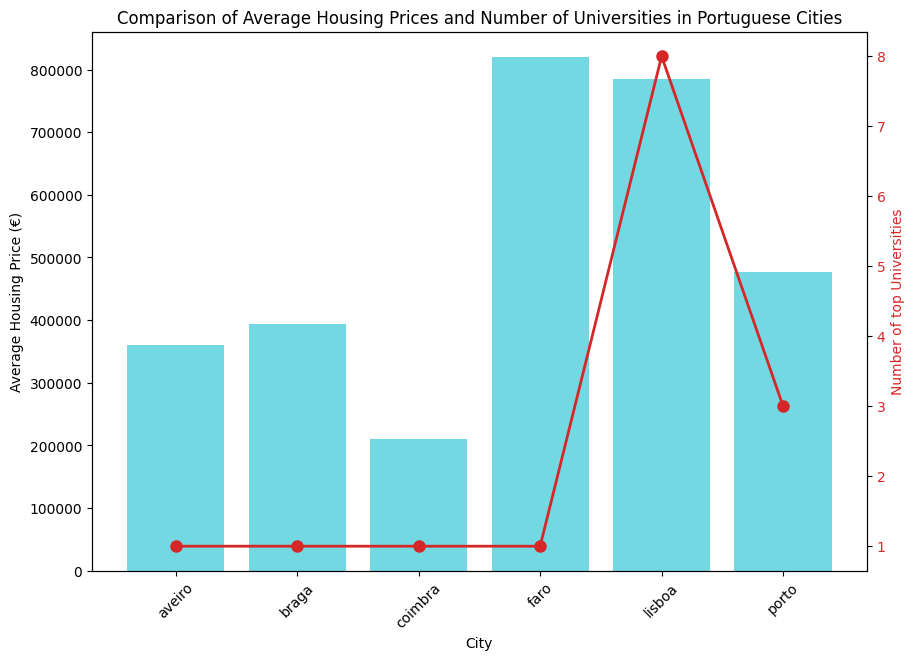

In [ ]:
#House prices in Lisboa are significantly higher than in other cities.
# Calculate average house prices for each city
average_prices = City_Houses_DF.groupby('city')['price_in_euros'].mean().reset_index()
average_prices.columns = ['city', 'average_price']

# Display the average prices
print(average_prices)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 7))

number_of_universities = [1, 1, 1, 1, 8, 3]
#City: ['Aveiro', 'Braga', 'Coimbra', 'Faro', 'Lisboa', 'Porto']

# Plotting Average Housing Price
color = 'tab:cyan'
ax1.set_xlabel('City')
ax1.set_ylabel('Average Housing Price (€)', color='black')
ax1.bar(average_prices['city'], average_prices['average_price'], color=color, alpha=0.6, label='Average Housing Price (€K)')
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticklabels(average_prices['city'], rotation=45)


# Creating a second y-axis to plot Number of Universities
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of top Universities', color= color)
ax2.plot(average_prices['city'], number_of_universities, color=color, marker='o', linestyle='-', linewidth=2, markersize=8, label='Number of top Universities')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Comparison of Average Housing Prices and Number of Universities in Portuguese Cities')

# Adding legends
#fig.tight_layout()
#fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [ ]:
#Faro has lower average house prices compared to coastal cities like Porto and Lisboa.

# Extract average prices for Faro, Porto, and Lisboa
coastal_cities = average_prices[average_prices['city'].isin(['faro', 'porto', 'lisboa'])]
print(coastal_cities)

     city  average_price
3    faro  819456.035503
4  lisboa  785522.904274
5   porto  477506.058161


In [ ]:
#Cities with higher tourism influx (e.g., Lisboa and Porto) have higher house prices due to increased demand for short-term rentals.
# Extract average prices for Lisboa and Porto
tourist_cities = average_prices[average_prices['city'].isin(['lisboa', 'porto'])]
non_tourist_cities = average_prices[~average_prices['city'].isin(['lisboa', 'porto'])]

print("Tourist Cities:")
print(tourist_cities)

print("Non-Tourist Cities:")
print(non_tourist_cities)

Tourist Cities:
     city  average_price
4  lisboa  785522.904274
5   porto  477506.058161
Non-Tourist Cities:
      city  average_price
0   aveiro  361023.779264
1    braga  393441.125461
2  coimbra  209829.350877
3     faro  819456.035503


In [ ]:
City_Houses_DF['house_typology'].unique()

array(['T5', 'T4', 'T2', 'T3', 'T1', 'T0'], dtype=object)

In [ ]:
#T0 and T1 apartments are less available in cities with high tourist demand (e.g., Lisboa and Porto) due to conversion into short-term rental properties (e.g., Airbnb).
# Count the number of T0 and T1 apartments in each city
typology_counts = City_Houses_DF[City_Houses_DF['house_typology'].isin(['T0', 'T1' ])].groupby('city').size().reset_index(name='count')
print(typology_counts)

      city  count
0   aveiro      8
1    braga      6
2  coimbra     35
3     faro     27
4   lisboa     14
5    porto     14


In [ ]:
# Filter the DataFrame for relevant typologies
filtered_df = City_Houses_DF[City_Houses_DF['house_typology'].isin(['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6'])]

# Group by city and house_typology and count the occurrences
typology_counts = filtered_df.groupby(['city', 'house_typology']).size().reset_index(name='count')

# Pivot the table to have cities as rows and typologies as columns for better readability
typology_pivot = typology_counts.pivot(index='city', columns='house_typology', values='count').fillna(0).astype(int)

# Display the pivot table
print(typology_pivot)


house_typology  T0  T1   T2   T3   T4  T5
city                                     
aveiro           1   7   58  297  198  37
braga            3   3   25  342  145  24
coimbra          4  31  146  199  174  73
faro             0  27  104  229  114  33
lisboa           0  14   61  233  183  94
porto            3  11   63  242  176  38


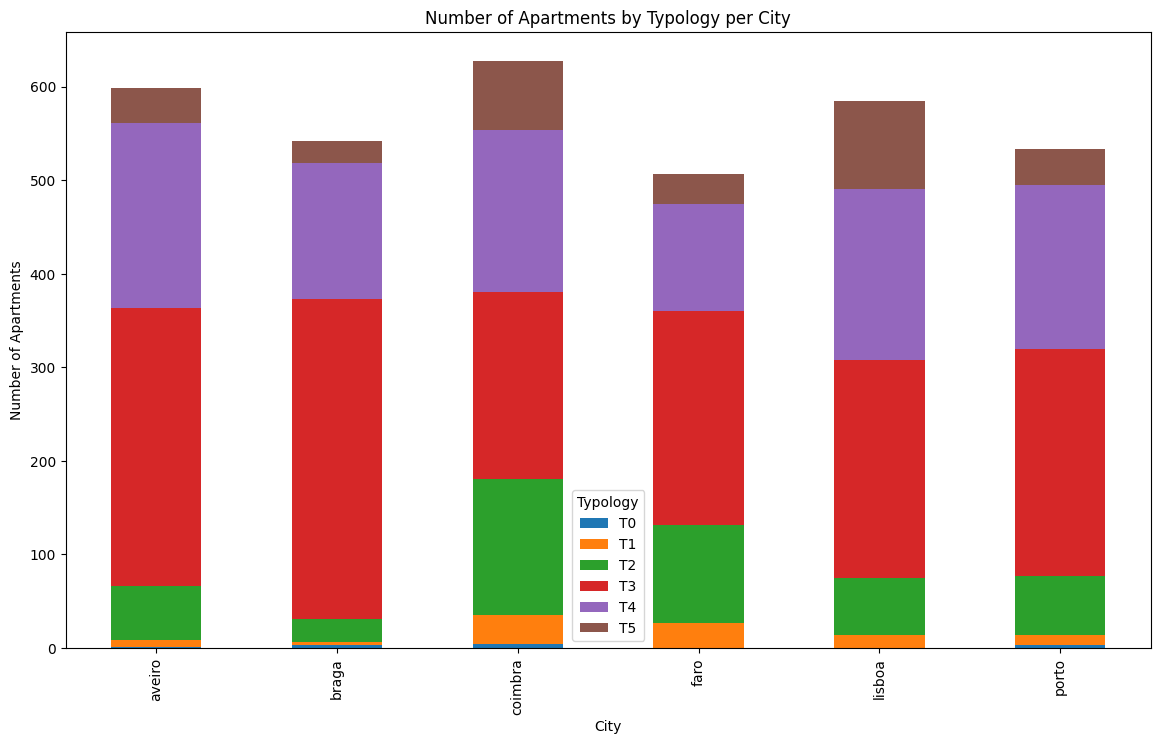

In [ ]:
# Plotting the number of apartments by typology per city
typology_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Number of Apartments by Typology per City')
plt.xlabel('City')
plt.ylabel('Number of Apartments')
plt.legend(title='Typology')
plt.show()

In [ ]:
# prompt: grupo by typology and citys showing in last colun and rouws the total number

# Filter the DataFrame for relevant typologies
filtered_df = City_Houses_DF[City_Houses_DF['house_typology'].isin(['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6'])]

# Group by house_typology and city and count the occurrences
typology_counts = filtered_df.groupby(['house_typology', 'city']).size().reset_index(name='count')

# Pivot the table to have typologies as rows and cities as columns
typology_pivot = typology_counts.pivot(index='house_typology', columns='city', values='count').fillna(0).astype(int)

# Calculate the total count for each typology (row)
#typology_pivot['Total'] = typology_pivot.sum(axis=1)

# Calculate the total count for each city (column)
#typology_pivot.loc['Total'] = typology_pivot.sum()

# Display the pivot table
print(typology_pivot)


city            aveiro  braga  coimbra  faro  lisboa  porto
house_typology                                             
T0                   1      3        4     0       0      3
T1                   7      3       31    27      14     11
T2                  58     25      146   104      61     63
T3                 297    342      199   229     233    242
T4                 198    145      174   114     183    176
T5                  37     24       73    33      94     38


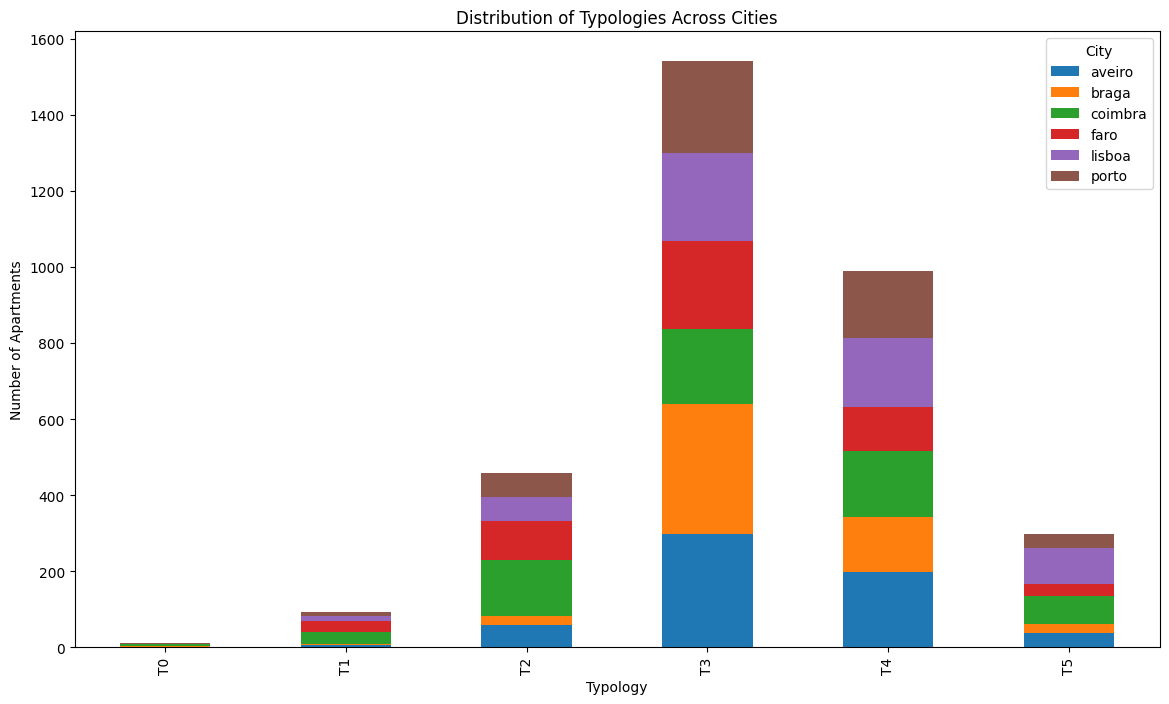

In [ ]:
# Plotting the distribution of typologies across cities
typology_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Distribution of Typologies Across Cities')
plt.xlabel('Typology')
plt.ylabel('Number of Apartments')
plt.legend(title='City')
plt.show()

In [ ]:
# Extract counts for Coimbra
coimbra_counts = typology_counts[typology_counts['city'] == 'coimbra']
print(coimbra_counts)

   house_typology     city  count
2              T0  coimbra      4
6              T1  coimbra     31
12             T2  coimbra    146
18             T3  coimbra    199
24             T4  coimbra    174
30             T5  coimbra     73


In [ ]:
#Larger cities (e.g., Lisboa and Porto) have a more diverse availability of housing typologies compared to smaller cities (e.g., Braga and Aveiro), but with a higher price per square meter for T0 and T1 apartments due to higher demand.
# Calculate diversity of housing typologies
typology_diversity = City_Houses_DF.groupby('city')['house_typology'].nunique().reset_index()
typology_diversity.columns = ['city', 'typology_diversity']

print("Diversity of housing typologies:")
print(typology_diversity)

# Calculate price per square meter for T2 to T5 houses
price_per_m2 = City_Houses_DF[City_Houses_DF['house_typology'].isin(['T2','T3','T4','T5'])].copy()
price_per_m2['price_per_m2'] = price_per_m2['price_in_euros'] / price_per_m2['size_m2']
average_price_per_m2 = price_per_m2.groupby('city')['price_per_m2'].mean().reset_index()
print("Average price per square meter for T2 to T5 houses:")
print(average_price_per_m2)

Diversity of housing typologies:
      city  typology_diversity
0   aveiro                   6
1    braga                   6
2  coimbra                   6
3     faro                   5
4   lisboa                   5
5    porto                   6
Average price per square meter for T2 to T5 houses:
      city  price_per_m2
0   aveiro   1872.762119
1    braga   1832.222573
2  coimbra   1312.498599
3     faro   4682.436917
4   lisboa   3713.837718
5    porto   2412.856101


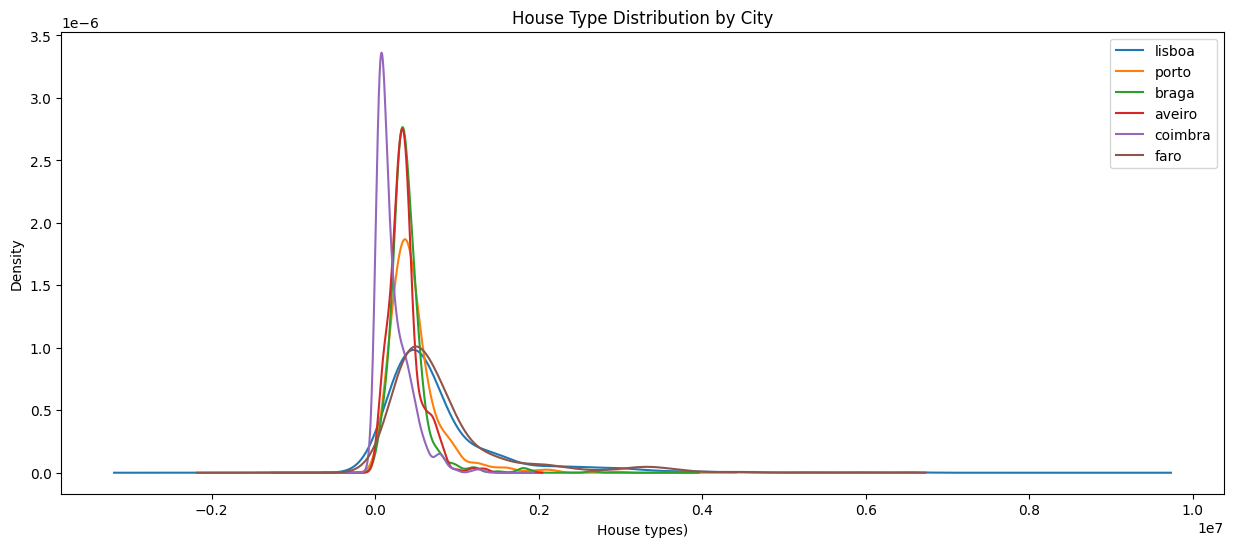

In [ ]:
#Price Distribution by City
plt.figure(figsize=(15, 6))
for city in cities:
    subset = City_Houses_DF[City_Houses_DF['city'] == city]
    subset['price_in_euros'].plot(kind='density', label=city)
plt.legend()
plt.xlabel('House types)')
plt.title('House Type Distribution by City')
plt.show()

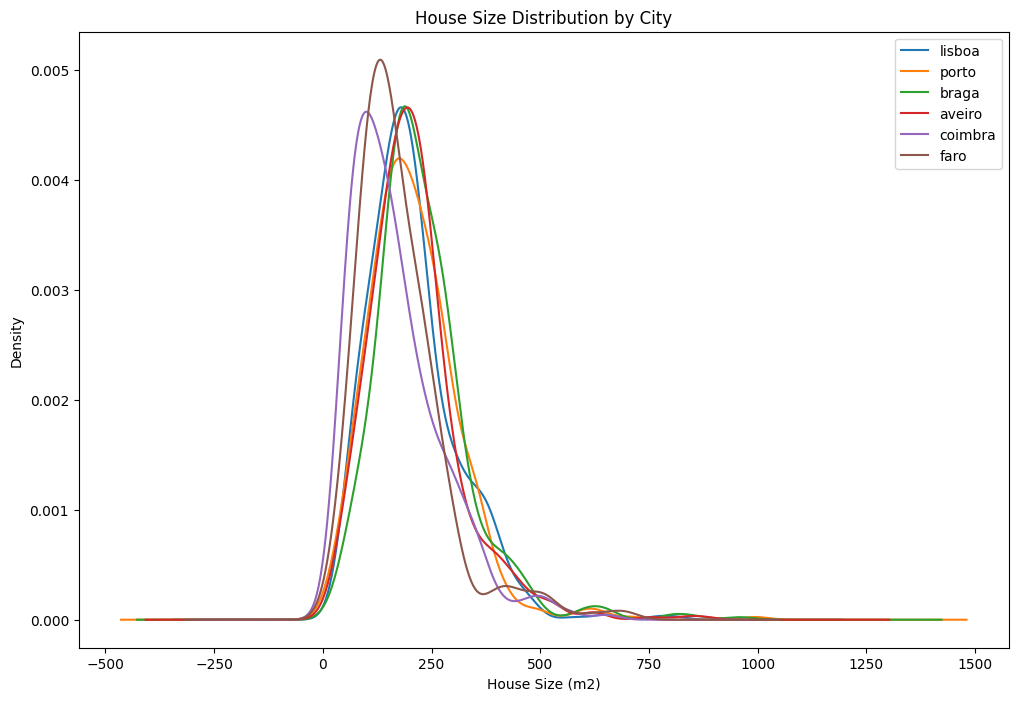

In [ ]:
#Size Distribution by City
plt.figure(figsize=(12, 8))
for city in cities:
    subset = City_Houses_DF[City_Houses_DF['city'] == city]
    subset['size_m2'].plot(kind='density', label=city)
plt.legend()
plt.xlabel('House Size (m2)')
plt.title('House Size Distribution by City')
plt.show()

In [ ]:
#Median Prices by City
median_prices = City_Houses_DF.groupby('city')['price_in_euros'].median().reset_index()
median_prices.columns = ['city', 'median_price']
print(median_prices)


      city  median_price
0   aveiro      340000.0
1    braga      350000.0
2  coimbra      140000.0
3     faro      600000.0
4   lisboa      565000.0
5    porto      395000.0


In [ ]:
City_Houses_DF

,title,price_in_euros,location_date,size_m2,city,house_typology,house_type,price_per_m2
0,Moradia T5 Piscina Cascais/Murtal,1050000.0,Carcavelos E Parede - Hoje às 16:08,250,lisboa,T5,Moradia,4200.000000
1,Moradia independente T4 com jardim e piscina e...,950000.0,Rio de Mouro - Hoje às 16:04,405,lisboa,T4,Moradia,2345.679012
2,Moradia T5 com piscina e jardim na Serra de Ca...,699000.0,Venteira - Hoje às 16:02,204,lisboa,T5,Moradia,3426.470588
3,Moradia T4,469000.0,"Alhandra, São João Dos Montes E Calhandriz - H...",231,lisboa,T4,Moradia,2030.303030
4,Moradia T5 Em Carcavelos Com Piscina E Jardim...,1350000.0,Carcavelos E Parede - Hoje às 16:01,139,lisboa,T5,Moradia,9712.230216
...,...,...,...,...,...,...,...,...
3402,Moradia T4 - Altura,430000.0,Altura - 24 de julho de 2024,137,faro,T4,Moradia,3138.686131
3403,Moradia T2+2 em Construção,393000.0,Vila Nova de Cacela - 24 de julho de 2024,93,faro,T2,Moradia,4225.806452
3404,Moradia T2+2 em Construção,384000.0,Vila Nova de Cacela - 24 de julho de 2024,108,faro,T2,Moradia,3555.555556
3405,Excelente Moradia T4 em Altura,530000.0,Altura - 24 de julho de 2024,201,faro,T4,Moradia,2636.815920


In [ ]:
City_Houses_DF.describe()

,price_in_euros,size_m2,price_per_m2
count,3.392000e+03,3392.000000,3392.000000
mean,4.982919e+05,199.843160,2582.039428
std,5.198796e+05,108.629244,2032.400882
min,2.000000e+04,20.000000,88.339223
25%,2.400000e+05,126.000000,1353.143960
50%,3.750000e+05,182.000000,2059.631545
75%,5.750000e+05,250.000000,3166.666667
max,6.500000e+06,994.000000,22037.037037


In [ ]:
City_Houses_DF["price_per_m2"]= City_Houses_DF["price_in_euros"]/City_Houses_DF["size_m2"]

In [ ]:
City_Houses_DF

,title,price_in_euros,location_date,size_m2,city,house_typology,house_type,price_per_m2
0,Moradia T5 Piscina Cascais/Murtal,1050000.0,Carcavelos E Parede - Hoje às 16:08,250,lisboa,T5,Moradia,4200.000000
1,Moradia independente T4 com jardim e piscina e...,950000.0,Rio de Mouro - Hoje às 16:04,405,lisboa,T4,Moradia,2345.679012
2,Moradia T5 com piscina e jardim na Serra de Ca...,699000.0,Venteira - Hoje às 16:02,204,lisboa,T5,Moradia,3426.470588
3,Moradia T4,469000.0,"Alhandra, São João Dos Montes E Calhandriz - H...",231,lisboa,T4,Moradia,2030.303030
4,Moradia T5 Em Carcavelos Com Piscina E Jardim...,1350000.0,Carcavelos E Parede - Hoje às 16:01,139,lisboa,T5,Moradia,9712.230216
...,...,...,...,...,...,...,...,...
3402,Moradia T4 - Altura,430000.0,Altura - 24 de julho de 2024,137,faro,T4,Moradia,3138.686131
3403,Moradia T2+2 em Construção,393000.0,Vila Nova de Cacela - 24 de julho de 2024,93,faro,T2,Moradia,4225.806452
3404,Moradia T2+2 em Construção,384000.0,Vila Nova de Cacela - 24 de julho de 2024,108,faro,T2,Moradia,3555.555556
3405,Excelente Moradia T4 em Altura,530000.0,Altura - 24 de julho de 2024,201,faro,T4,Moradia,2636.815920


In [ ]:
#locating anomaly

##City_Houses_DF.loc[(City_Houses_DF['city'] ==  'aveiro') &( City_Houses_DF["house_typology"]=="T5")]

In [ ]:

City_Houses_DF.isnull().sum()

title              0
price_in_euros     0
location_date      0
size_m2            0
city               0
house_typology     0
house_type        47
price_per_m2       0
dtype: int64

In [ ]:
City_Houses_DF = City_Houses_DF[City_Houses_DF['house_typology'].isin(['T0', 'T1', 'T2', 'T3', 'T4', 'T5'])]


grouped_df = City_Houses_DF.groupby(['city', 'house_typology']).agg({'price_per_m2': 'mean'}).reset_index()

print("Grouped Data:")
print(grouped_df)

Grouped Data:
       city house_typology  price_per_m2
0    aveiro             T0   2338.709677
1    aveiro             T1   1502.405333
2    aveiro             T2   1938.576619
3    aveiro             T3   1894.211670
4    aveiro             T4   1881.471334
5    aveiro             T5   1550.811251
6     braga             T0   1275.660309
7     braga             T1   1696.780045
8     braga             T2   2024.094175
9     braga             T3   1828.785395
10    braga             T4   1801.814512
11    braga             T5   1865.051484
12  coimbra             T0   1626.665611
13  coimbra             T1   1325.600352
14  coimbra             T2   1051.662472
15  coimbra             T3   1172.020963
16  coimbra             T4   1534.077536
17  coimbra             T5   1688.969685
18     faro             T1   4523.252962
19     faro             T2   4157.697209
20     faro             T3   4591.692670
21     faro             T4   5180.311915
22     faro             T5   5245.940322
23

In [ ]:
grouped_df1 = grouped_df.pivot(index = "city", columns = "house_typology", values = "price_per_m2")
grouped_df1

house_typology,T0,T1,T2,T3,T4,T5
city,,,,,,
aveiro,2338.709677,1502.405333,1938.576619,1894.211670,1881.471334,1550.811251
braga,1275.660309,1696.780045,2024.094175,1828.785395,1801.814512,1865.051484
coimbra,1626.665611,1325.600352,1051.662472,1172.020963,1534.077536,1688.969685
faro,NaN,4523.252962,4157.697209,4591.692670,5180.311915,5245.940322
lisboa,NaN,2031.205503,3061.001592,3468.312603,4075.917685,4041.175178
porto,2207.130664,4297.727902,2732.746828,2296.181632,2531.275434,2077.074598


In [ ]:
grouped_df1.round(decimals = 2)

house_typology,T0,T1,T2,T3,T4,T5
city,,,,,,
aveiro,2338.71,1502.41,1938.58,1894.21,1881.47,1550.81
braga,1275.66,1696.78,2024.09,1828.79,1801.81,1865.05
coimbra,1626.67,1325.60,1051.66,1172.02,1534.08,1688.97
faro,NaN,4523.25,4157.70,4591.69,5180.31,5245.94
lisboa,NaN,2031.21,3061.00,3468.31,4075.92,4041.18
porto,2207.13,4297.73,2732.75,2296.18,2531.28,2077.07


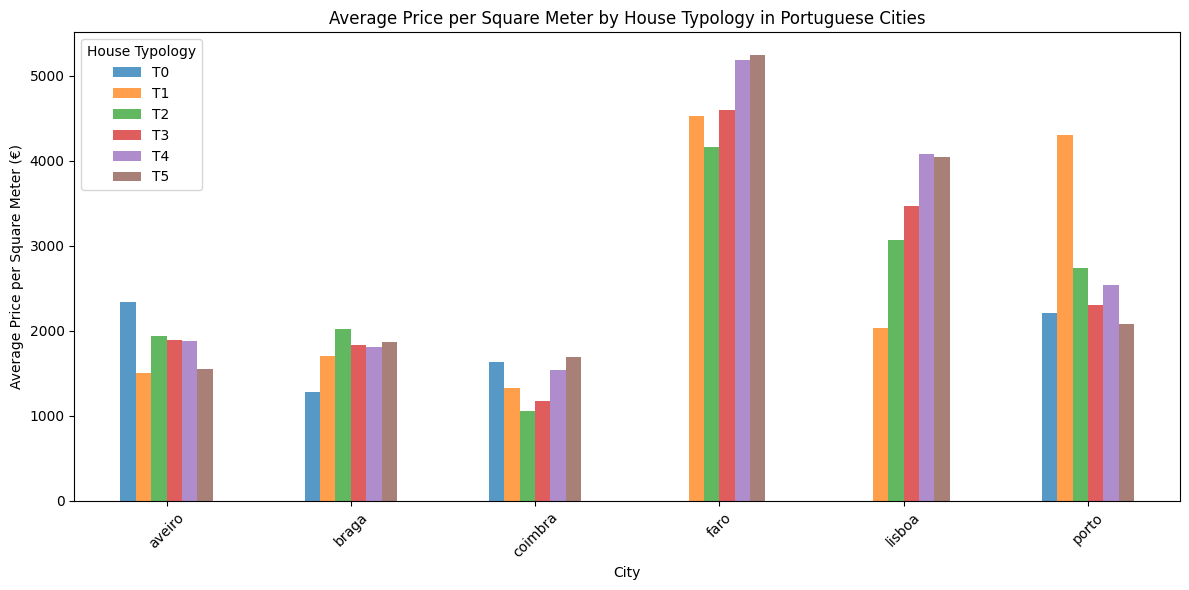

In [ ]:
# Plotting the grouped data
fig, ax = plt.subplots(figsize=(12, 6))

# Use pivot to reshape data for easier plotting
pivot_df = grouped_df.pivot(index='city', columns='house_typology', values='price_per_m2')

# Plot each house_typology as a different bar in the same plot
pivot_df.plot(kind='bar', ax=ax, alpha=0.75)

ax.set_xlabel('City')
ax.set_ylabel('Average Price per Square Meter (€)')
ax.set_title('Average Price per Square Meter by House Typology in Portuguese Cities')
ax.legend(title='House Typology')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
City_Houses_DF.describe()

,price_in_euros,size_m2,price_per_m2
count,3.392000e+03,3392.000000,3392.000000
mean,4.982919e+05,199.843160,2582.039428
std,5.198796e+05,108.629244,2032.400882
min,2.000000e+04,20.000000,88.339223
25%,2.400000e+05,126.000000,1353.143960
50%,3.750000e+05,182.000000,2059.631545
75%,5.750000e+05,250.000000,3166.666667
max,6.500000e+06,994.000000,22037.037037
